In [1]:
import os
import gzip
import json
import math
import random
import pickle
import pprint
import argparse

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
def convert_unique_idx(df, column_name):
    column_dict = {x: i for i, x in enumerate(df[column_name].unique())}
    df[column_name] = df[column_name].apply(column_dict.get)
    df[column_name] = df[column_name].astype('int')
    assert df[column_name].min() == 0
    assert df[column_name].max() == len(column_dict) - 1
    return df, column_dict


def create_user_list(df, user_size):
    user_list = [list() for u in range(user_size)]
    for row in df.itertuples():
        user_list[row.user].append(row.item)
    return user_list


def split_train_test(df, user_size, test_size=0.2):
    """Split a dataset into `train_user_list` and `test_user_list`.
    Because it needs `user_list` for splitting dataset as `time_order` is set,
    Returning `user_list` data structure will be a good choice."""
    total_user_list = create_user_list(df, user_size)
    train_user_list = [None] * len(total_user_list)
    test_user_list = [None] * len(total_user_list)
    for user, item_list in enumerate(total_user_list):
        # Split item
        test_item = item_list[math.ceil(len(item_list)*(1-test_size)):]
        train_item = item_list[:math.ceil(len(item_list)*(1-test_size))]
        # Register to each user list
        test_user_list[user] = test_item
        train_user_list[user] = train_item
        
    return train_user_list, test_user_list


def create_pair(user_list):
    pair = []
    for user, item_list in enumerate(user_list):
        pair.extend([(user, item) for item in item_list])
    return pair


In [3]:
class MIND:
  def __init__(self, path='./large_train.csv'):
    self.df = pd.read_csv(path, names = ["user", 'item']).drop_duplicates()

  def load(self):
    self.analyse()
    return self.df

  def remove_noise_user(self):
    # remove user who read less than 25% percent and large than 75% percent
    self.df = self.df.groupby('user').filter(lambda gr: gr['item'].nunique() >= 7 and gr['item'].nunique() <= 33)
    self.analyse()

  def remove_noise_item(self):
    self.df = self.df.groupby('item').filter(lambda gr: gr['user'].nunique() >= 2)
    self.analyse()

  def analyse(self):
    print('Shape', self.df.shape)
    print('User distribution')
    print(self.df.groupby('user')['item'].nunique().describe())
    print('Item distribution')
    print(self.df.groupby('item')['user'].nunique().describe())

In [4]:
mind = MIND()

In [5]:
his = mind.load()

Shape (6475520, 2)
User distribution
count    248973.000000
mean         26.008925
std          31.382382
min           1.000000
25%           7.000000
50%          15.000000
75%          33.000000
max         785.000000
Name: item, dtype: float64
Item distribution
count    66296.000000
mean        97.675878
std        557.134669
min          1.000000
25%          1.000000
50%          3.000000
75%         15.000000
max      29340.000000
Name: user, dtype: float64


In [6]:
mind.remove_noise_user()

Shape (2173850, 2)
User distribution
count    131171.000000
mean         16.572642
std           7.449364
min           7.000000
25%          10.000000
50%          15.000000
75%          22.000000
max          33.000000
Name: item, dtype: float64
Item distribution
count    44510.000000
mean        48.839587
std        264.518652
min          1.000000
25%          1.000000
50%          2.000000
75%         14.000000
max      13411.000000
Name: user, dtype: float64


<AxesSubplot:>

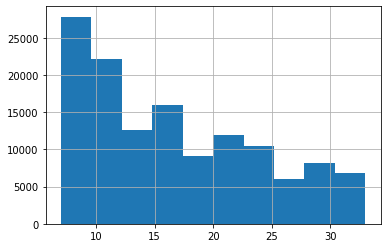

In [7]:
mind.df.groupby('user')['item'].nunique().hist()

In [8]:
mind.remove_noise_item()

Shape (2157632, 2)
User distribution
count    131171.000000
mean         16.449002
std           7.400974
min           2.000000
25%          10.000000
50%          15.000000
75%          22.000000
max          33.000000
Name: item, dtype: float64
Item distribution
count    28292.000000
mean        76.262972
std        328.659253
min          2.000000
25%          3.000000
50%          7.000000
75%         39.000000
max      13411.000000
Name: user, dtype: float64


<AxesSubplot:>

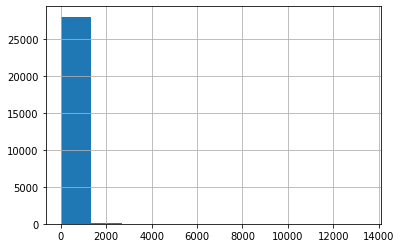

In [9]:
mind.df.groupby('item')['user'].nunique().hist()

In [10]:
df, user_mapping = convert_unique_idx(mind.df, 'user')
df, item_mapping = convert_unique_idx(df, 'item')

In [11]:
user_size = len(df['user'].unique())
item_size = len(df['item'].unique())
train_user_list, test_user_list = split_train_test(df, user_size, test_size=0.2)

In [12]:
train_pair = create_pair(train_user_list)

In [13]:
dataset = {'user_size': user_size, 'item_size': item_size, 
               'user_mapping': user_mapping, 'item_mapping': item_mapping,
               'train_user_list': train_user_list, 'test_user_list': test_user_list,
               'train_pair': train_pair}

In [14]:
with open('./mind_large_behav_sh04166.pickle', 'wb') as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
!cp /content/mind_large_behav_sh0416.pickle /content/drive/MyDrive/Thesis/Data/raw_large

cp: cannot stat '/content/mind_large_behav_sh0416.pickle': No such file or directory
